In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem, zscore
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle
from skimage import io
import glob

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
%%time
# fly_num = 'fly_241'
# func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
later_dir = '/oak/stanford/groups/trc/data/Ilana/2P/data/later/'
# func_path = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/{fly_num}/'


CPU times: user 6 µs, sys: 5 µs, total: 11 µs
Wall time: 19.1 µs


In [3]:
%%time
# print(os.listdir(later_dir))
total_warps = []
for x in sorted(os.listdir(later_dir)):
    if 'warp' in x :
        temp = np.load(os.path.join(later_dir,x))
        total_warps.append(temp)
print(np.shape(total_warps)[0])
total_warps = np.asarray(np.mean(total_warps, axis=0))
total_warp_path = os.path.join(later_dir, 'total_warps.npy')
np.save(total_warp_path, total_warps)

9
CPU times: user 2.27 s, sys: 8.69 s, total: 11 s
Wall time: 22.7 s


In [ ]:
%%time
total_behave = []
shape = 196 #this is hard coded to be the smallest but i gotta figure this shit out better
for x in sorted(os.listdir(later_dir)):
    if 'behavior' in x:
        temp = np.load(os.path.join(later_dir,x))
        print(np.shape(temp))
        total_behave.append(temp[:shape,:])
print(np.shape(total_behave))
total_behave = np.asarray(np.mean(total_behave, axis=0))
total_behave_path = os.path.join(later_dir, 'total_behaves.npy')
np.save(total_behave_path, total_behave)

In [ ]:
np.shape(total_behave)

In [70]:
fly_nums = []
total_behave = []
total_behave_norm = []
total_behave_norm1 = []
total_behave_norm2 = []
total_behave_norm3 = []
shape = 196 #this is hard coded to be the smallest but i gotta figure this shit out better
for x in sorted(os.listdir(later_dir)):
    if 'behavior' in x:
        fly_nums.append(x[:7])
        temp = np.load(os.path.join(later_dir,x))
        total_behave.append(temp[:shape,:])
        pre_v = temp[:,100:200]
#         pre_v = np.asarray(pre_v)
        mean_pre = np.mean(pre_v)
        std_pre = np.std(pre_v)
        temp_norm = (temp-mean_pre)/std_pre
        total_behave_norm.append(temp_norm[:shape,:])
        temp_norm1 = (temp-mean_pre)/mean_pre
        total_behave_norm1.append(temp_norm1[:shape,:])
        temp_norm2 = temp/mean_pre
        total_behave_norm2.append(temp_norm2[:shape,:])
        temp_z = zscore(temp, axis=1)
        total_behave_norm3.append(temp_z[:shape,:])
#         print(np.shape(temp_norm))
        
# plt.plot(temp_norm.T);
total_behave = np.asarray(total_behave)
total_behave_norm = np.asarray(total_behave_norm)
total_behave_norm1 = np.asarray(total_behave_norm1)
total_behave_norm2 = np.asarray(total_behave_norm2)
total_behave_norm3 = np.asarray(total_behave_norm3)
print(np.shape(total_behave))
print(np.shape(total_behave_norm))
print(np.shape(total_behave_norm1))
print(np.shape(total_behave_norm2))
print(np.shape(total_behave_norm3))
print(fly_nums)

(9, 196, 500)
(9, 196, 500)
(9, 196, 500)
(9, 196, 500)
(9, 196, 500)
['fly_208', 'fly_209', 'fly_210', 'fly_217', 'fly_218', 'fly_227', 'fly_228', 'fly_234', 'fly_240']


(500,)
(500,)


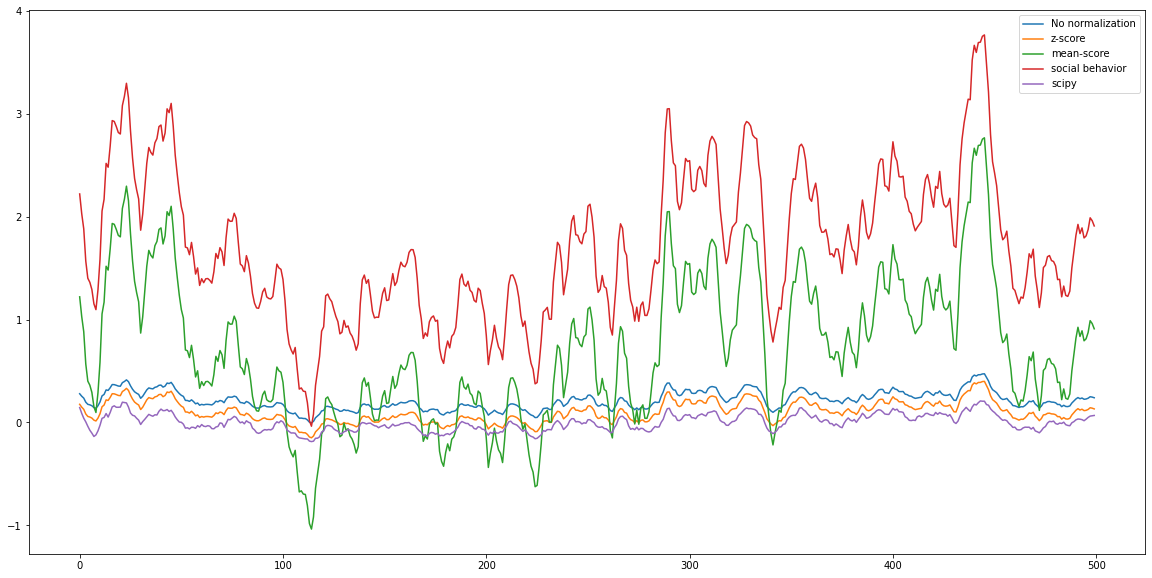

In [76]:
fly = 4

a=np.mean(total_behave[fly,:,:], axis=0)
print(np.shape(a))
b=np.mean(total_behave_norm[fly,:,:], axis=0)
print(np.shape(b))
c=np.mean(total_behave_norm1[fly,:,:], axis=0)
d=np.mean(total_behave_norm2[fly,:,:], axis=0)
e=np.mean(total_behave_norm3[fly,:,:], axis=0)
fig, ax = plt.subplots(figsize=(20,10))
# fig.subplots(figsize=(10,10))
ax.plot(a.T, label='No normalization')
ax.plot(b.T, label='z-score')
ax.plot(c.T, label='mean-score')
ax.plot(d.T, label='social behavior')
ax.plot(e.T, label='scipy')
ax.legend()

(9, 500)


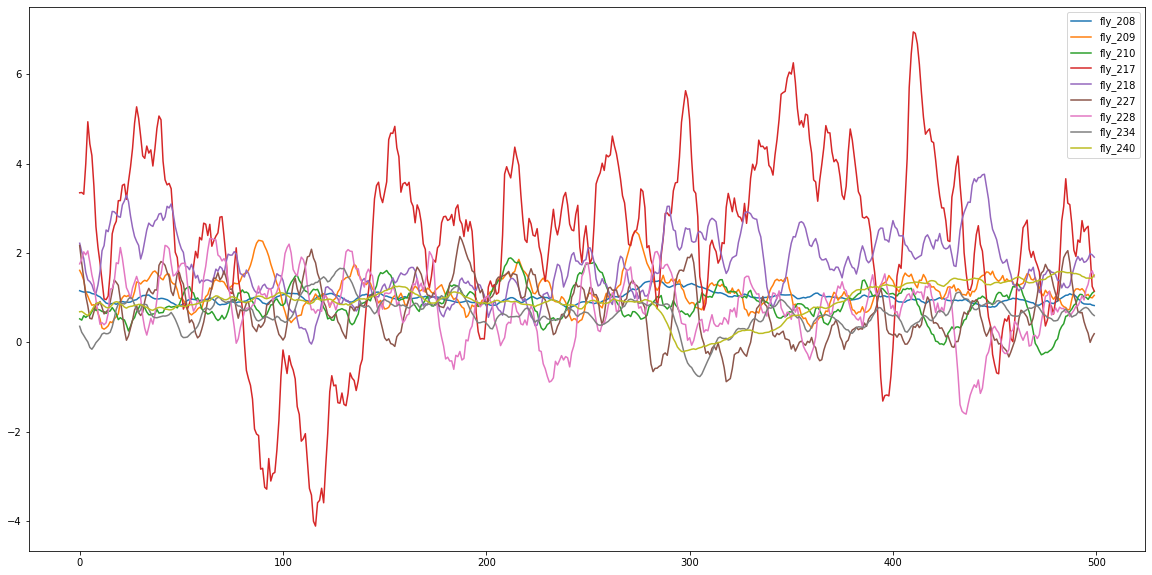

In [72]:
f=np.mean(total_behave_norm2, axis=1)
print(np.shape(f))
fig, ax = plt.subplots(figsize=(20,10))
for i in range(np.shape(total_behave_norm2)[0]):
    ax.plot(f[i,:].T, label=fly_nums[i])
ax.legend()
# ax.plot(np.mean(total_behave, axis=1).T)

In [51]:
norm_behavior=total_behave_norm
behavior = total_behave
print(np.shape(norm_behavior))
print(np.shape(behavior))
# plt.plot(np.mean(norm_behavior,axis=0));

(9, 196, 500)
(9, 196, 500)


In [41]:
def plot_trace(behavior_trace, pre_window, post_window, stim_time, ax=None, fig=None):
    mean_trace = np.mean(behavior_trace, axis=0)
    sem_trace = scipy.stats.sem(behavior_trace, axis=0)
    color='b'
    
    if ax==None:
        fig, ax = plt.subplots(figsize=(10,10))
        color='k'
#     plt.figure(figsize=(10,10))
    ax.plot(mean_trace,color=color,linewidth=3)
    ax.fill_between(np.arange(np.shape(mean_trace)[0]),mean_trace-sem_trace, mean_trace+sem_trace, color='k',alpha=0.3)
    ax.axvline(pre_window,color='k',linestyle='--',lw=2)
    ax.axvline(pre_window+stim_time,color='k',linestyle='--',lw=2)
    ax.set_ylim(-0.5, 3.5);
    return fig, ax

(None, <AxesSubplot:>)

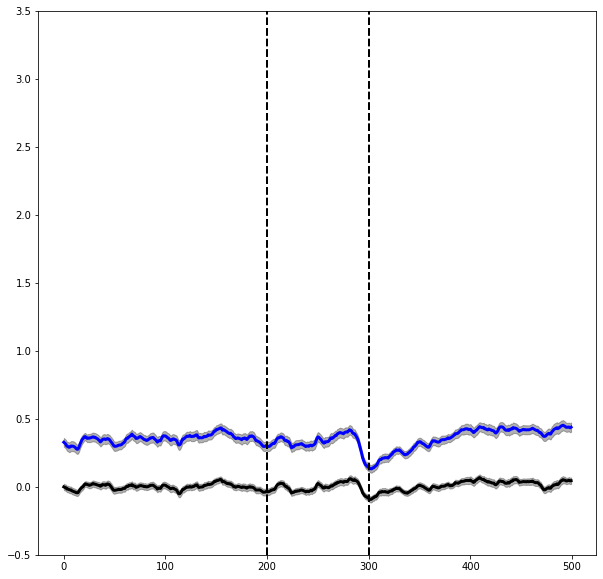

In [52]:
pre_window = 200
post_window = 300
stim_time = 100
avg_norm = np.mean(norm_behavior,axis=0)
avg_gen = np.mean(behavior,axis=0)
fig, ax = plot_trace(avg_norm, pre_window, post_window, stim_time)
plot_trace(avg_gen, pre_window, post_window, stim_time, ax=ax)

In [13]:
def get_vals_for_analysis(tp_width_sec=0, trial_time_sec=0, before_stim_sec=0, pre_trial_window_sec=0, pre_trial_size_sec=0, post_trial_window_sec=0, post_trial_size_sec=0, thresh=0):
        
    stim_end_sec = before_stim_sec + trial_time_sec
    
    stim_idx = int(before_stim_sec/tp_width_sec)
    stim_end_idx = int(stim_end_sec/tp_width_sec)
    pre_trial_window_idx = int(pre_trial_window_sec/tp_width_sec)

    # first val i use to make delta to compare change in vel
    first_val_end_idx = int(stim_idx - pre_trial_window_idx)
    first_val_start_idx = int(first_val_end_idx - (pre_trial_size_sec/tp_width_sec)) #only needed if you're averaging across a window, otherwise just start val is used

    # second val used to make delta
    second_val_start_idx = int(stim_idx + post_trial_size_sec/tp_width_sec)
    second_val_end_idx = int(second_val_start_idx + post_trial_window_sec/tp_width_sec)
    return stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx

In [14]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, method="gust")
    return y

In [15]:
def apply_butter_lowpass(behavior_traces, stim_idx, fr):
    # Filter requirements.
    order = 4
    fs = fr      # sample rate, Hz
    cutoff = 3  # desired cutoff frequency of the filter, Hz

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

#     # Plot the frequency response.
#     w, h = freqz(b, a, fs=fs, worN=8000)
#     plt.subplot(2, 1, 1)
#     plt.plot(w, np.abs(h), 'b')
#     plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
#     plt.axvline(cutoff, color='k')
#     plt.xlim(0, 0.5*fs)
#     plt.title("Lowpass Filter Frequency Response")
#     plt.xlabel('Frequency [Hz]')
#     # plt.grid()

    # Filter the data, and plot both the original and filtered signals.
    lpf_behavior = np.zeros((behavior_traces.shape[0], behavior_traces.shape[1] - stim_idx))

    for i in range(behavior_traces.shape[0]):
        lpf_behavior[i, :] = butter_lowpass_filter(behavior_traces[i,stim_idx:], cutoff, fs, order)

#     plt.subplot(2, 1, 2)
#     plt.plot(np.mean(behavior_traces[:, stim_idx:], axis=0), 'b-', label='data')
#     plt.plot(np.mean(lpf_behavior, axis=0), 'g-', linewidth=2, label='filtered data')
#     # plt.plot(np.mean(lpf_behavior_QC, axis=0), 'r-', linewidth=2, label='QC filtered data')
#     plt.xlabel('Time')
#     # plt.grid()
#     plt.legend()

#     plt.subplots_adjust(hspace=0.35)
#     plt.show()
    return lpf_behavior

In [16]:
def get_speed_change(behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx):
    pre_tsi= first_val_start_idx-stim_idx
    pre_tei = first_val_end_idx-stim_idx
    post_tsi = second_val_start_idx-stim_idx
    post_tei = second_val_end_idx-stim_idx
    
    if first_val_start_idx!=first_val_end_idx:
        first_speed = np.mean(behavior[:,pre_tsi:pre_tei], axis = 1)
    else:
        first_val_start_idx = int(first_val_start_idx)
        first_speed = np.asarray(behavior[:,pre_tsi])

    if second_val_start_idx!=second_val_end_idx:
        second_speed = np.mean(behavior[:,post_tsi:post_tei], axis = 1)
    else: 
        second_speed = np.asarray(behavior[:,post_tsi])
    speed_change = second_speed-first_speed
    return speed_change

In [17]:
def get_trials(speed_change, thresh):
    decrease_trials = speed_change <-thresh
    decrease_idx = np.where(decrease_trials)
    increase_trials = speed_change>thresh
    increase_idx = np.where(increase_trials)
    flat_trials = np.logical_and(speed_change>-thresh, speed_change<thresh)
    flat_idx = np.where(flat_trials)
    return increase_trials, decrease_trials, flat_trials

In [18]:

def validate_trial(trial_idx, trace=None):
    """ Visualize a single trial, along with the pre and post averaging windows
    
    RED: pre window
    YELLOW: post window
    BLUE: stim time
    """
    if trace is None:
        trace = behavior_traces[trial_idx]
    plt.plot(trace)
    plt.axvline(first_val_start_idx, color='r')
    plt.axvline(first_val_end_idx, color='r')
    plt.axvline(second_val_start_idx, color='y')
    plt.axvline(second_val_end_idx, color='y')
    plt.axvline(stim_idx, color='b')


def validate_windows(behavior_traces, value_struct, fr):
    """ Visualize average traces for both slow and fast trials
    
    NOTE: uses global variables, must rerun constant cells and slow_ind logic to change results.
    
    RED: pre window
    YELLOW: post window
    BLUE: stim time
    """
    
    stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx = get_vals_for_analysis(**value_struct)
    lpf_behavior = apply_butter_lowpass(behavior_traces, stim_idx, fr)
    speed_change = get_speed_change(lpf_behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx)
    increase_trials, decrease_trials, flat_trials = get_trials(speed_change, value_struct["thresh"])
    increase_traces = behavior_traces[increase_trials]
    decrease_traces = behavior_traces[decrease_trials]
    flat_traces = behavior_traces[flat_trials]
    
    print(f"{len(increase_traces)} increase trials")
    print(f"{len(decrease_traces)} decrease trials")
    print(f"{len(flat_traces)} flat trials")
    
    increase_mean = np.mean(increase_traces, axis=0)
    increase_sem = scipy.stats.sem(increase_traces, axis=0)
    
    decrease_mean = np.mean(decrease_traces, axis=0)
    decrease_sem = scipy.stats.sem(decrease_traces, axis=0)
    
    flat_mean = np.mean(flat_traces, axis=0)
    flat_sem = scipy.stats.sem(flat_traces, axis=0)
    
    fig, axes = plt.subplots(nrows=3)
    
    axes[0].plot(increase_mean, color='k',linewidth=3)
    axes[0].set_ylim(-1, 3.5)
    axes[0].fill_between(np.arange(len(increase_mean)), increase_mean - increase_sem, increase_mean + increase_sem, color='k',alpha=0.3)
    axes[0].axvline(first_val_start_idx, color='r')
    axes[0].axvline(first_val_end_idx, color='r')
    axes[0].axvline(second_val_start_idx, color='y')
    axes[0].axvline(second_val_end_idx, color='y')
    axes[0].axvline(stim_idx, color='b', linestyle='--')
    axes[0].axvline(stim_end_idx, color='b', linestyle='--')
#     axes[0].set_title("slow trials")
    

    
    axes[1].plot(decrease_mean, color='k',linewidth=3)
    axes[1].set_ylim(-1, 3.5)
    axes[1].fill_between(np.arange(len(decrease_mean)), decrease_mean - decrease_sem, decrease_mean + decrease_sem, color='k',alpha=0.3)
    axes[1].axvline(first_val_start_idx, color='r')
    axes[1].axvline(first_val_end_idx, color='r')
    axes[1].axvline(second_val_start_idx, color='y')
    axes[1].axvline(second_val_end_idx, color='y')
    axes[1].axvline(stim_idx, color='b', linestyle='--')
    axes[1].axvline(stim_end_idx, color='b', linestyle='--')
    
    axes[2].plot(flat_mean, color='k',linewidth=3)
    axes[2].set_ylim(-1, 3.5)
    axes[2].fill_between(np.arange(len(flat_mean)), flat_mean - flat_sem, flat_mean + flat_sem, color='k',alpha=0.3)
    axes[2].axvline(first_val_start_idx, color='r')
    axes[2].axvline(first_val_end_idx, color='r')
    axes[2].axvline(second_val_start_idx, color='y')
    axes[2].axvline(second_val_end_idx, color='y')
    axes[2].axvline(stim_idx, color='b', linestyle='--')
    axes[2].axvline(stim_end_idx, color='b', linestyle='--')
    
    return fig, axes


In [19]:
# andrew anaylsis
value_struct ={
    # the data is in 10ms, use this value to get the index if i use seconds
    "tp_width_sec": 0.01,
    "trial_time_sec": 1,
    "before_stim_sec": pre_window/100,
    # time in seconds between end of pre trial window and the stimulus time. 
    # when set to zero, the pre trial window ends when the stimulus is presented
    "pre_trial_window_sec": -0.05,
    # size of window that pre trial speed is averaged over, seconds, window ends at stimulus time
    # when 0 is a single val and not a window
    "pre_trial_size_sec": 0,
    # size of post trial speed average window, sec
    "post_trial_window_sec": 0.5,
    # post trial window at stim tiem + post trail delay
    # when 0 is a single val and not a window
    "post_trial_size_sec": 0,
    "thresh": 0.05
    }

In [20]:
# behavior_traces = np.load(total_behave_path)

In [21]:
fr = 100.00033694743087

In [44]:
def make_traces(behavior, fr):
    increase_total= []
    decrease_total= []
    flat_total= []

    for fly in behavior:
        stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx = get_vals_for_analysis(**value_struct)
        lpf_behavior = apply_butter_lowpass(fly, stim_idx, fr)
        speed_change = get_speed_change(lpf_behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx)
        increase_trials, decrease_trials, flat_trials = get_trials(speed_change, value_struct["thresh"])
        increase_traces = fly[increase_trials]
    #     print(np.shape(increase_traces))
    #     print(np.shape(increase_total))
        increase_total.append(increase_traces)
        decrease_traces = fly[decrease_trials]
    #     print(np.shape(decrease_traces))
        decrease_total.append(decrease_traces)
        flat_traces = fly[flat_trials]
    #     print(np.shape(flat_traces))
        flat_total.append(flat_traces)

    increase_total=np.vstack(np.asarray(increase_total))
    print(np.shape(increase_total))
    decrease_total=np.vstack(np.asarray(decrease_total))
    print(np.shape(decrease_total))
    flat_total=np.vstack(np.asarray(flat_total))
    print(np.shape(flat_total))
    return increase_total, decrease_total, flat_total

In [54]:
#normalized
inc_n, dec_n, flat_n = make_traces(norm_behavior, fr)
#non-normalized
inc, dec, flat = make_traces(behavior, fr)

/home/users/ilanazs/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



(639, 500)
(615, 500)
(510, 500)
(657, 500)
(635, 500)
(472, 500)


(None, <AxesSubplot:>)

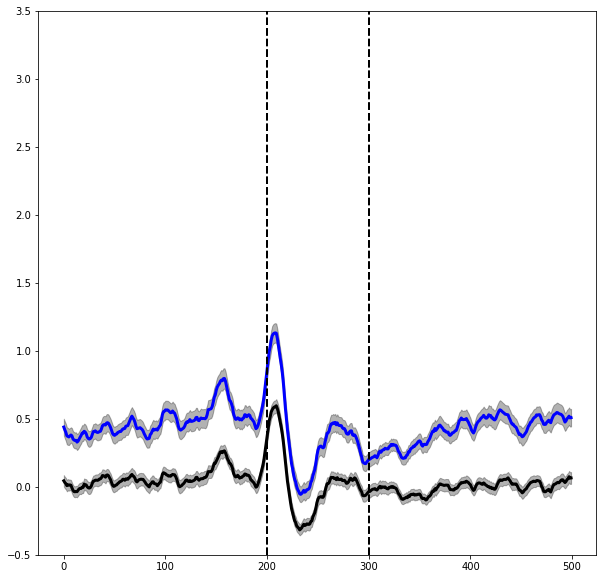

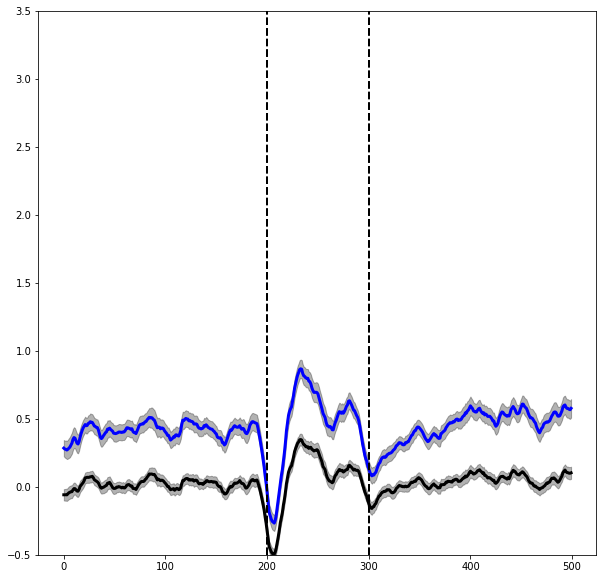

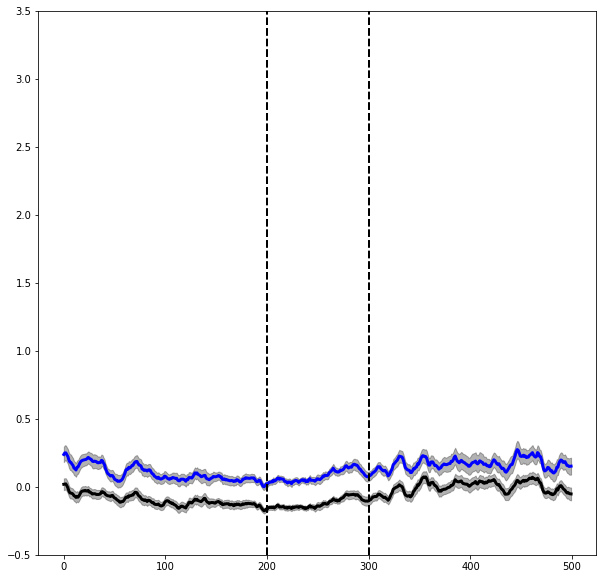

In [55]:
fig1,ax1 = plot_trace(dec_n, pre_window, post_window, stim_time)
plot_trace(dec, pre_window, post_window, stim_time, ax=ax1)
# print(np.shape(decrease_total))
fig2,ax2 = plot_trace(inc_n, pre_window, post_window, stim_time)
plot_trace(inc, pre_window, post_window, stim_time, ax=ax2)
# print(np.shape(increase_total))
fig3,ax3 = plot_trace(flat_n, pre_window, post_window, stim_time)
plot_trace(flat, pre_window, post_window, stim_time, ax=ax3)
# print(np.shape(flat_total))

In [ ]:
warps = np.load(total_warp_path)

In [ ]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [ ]:
explosions = []
t0 = time.time()
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[tp][:,:,::-1]
    vmax = 0.5 #this was 0.5 for STA <------------
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic', diverging=True)#'hot')
    explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')

In [ ]:
movie_dir = os.path.join(later_dir, 'movies')
if os.path.exists(movie_dir)==False:
    os.mkdir(movie_dir)
print(movie_dir)

In [ ]:
save_dir = os.path.join(movie_dir,'total')
if os.path.exists(save_dir)==False:
    os.mkdir(save_dir)
print(save_dir)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(24):
    print(i)
    plt.imshow(explosions[i][170:,:]) #this was made with cmap=hot
    fname = os.path.join(save_dir, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=300,bbox_inches='tight')